In [1]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from PIL import Image
import numpy as np

In [2]:
from pathlib import Path

## Dataset

The dataset is a set of audio recordings from cats. Samples are short clips (1-2 seconds) grouped in three classes:
- brushing the cat
- cat is in unfamiliar environment (discomfort)
- waiting for food

Source: https://zenodo.org/record/4008297 <br>
Paper: https://air.unimi.it/handle/2434/811133

In [3]:
dataset_dir = Path('/home/flo/projects/data-playground/data/catmeows/wav')
dataset_png = dataset_dir.parent / 'png'

## Convert audio samples into images of spectograms

In [4]:
from scipy.io import wavfile
from scipy import signal
import numpy as np

# source: https://stackoverflow.com/questions/47954034/plotting-spectrogram-in-audio-analysis/47954408
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [5]:
def wav_to_png(path_wav, overwrite=False):
    path_png = dataset_png / f'{path_wav.stem}.png'
    
    if path_png.exists() and not overwrite:
        return path_png

    # read wave file
    sample_rate, audio = wavfile.read(path_wav)

    # turn audio into spectogram
    freqs, times, specgram = log_specgram(audio, sample_rate)

    # bring into range 0..255
    specgram_normed = (specgram + abs(specgram.min())) / (abs(specgram.min()) + specgram.max())
    specgram_normed = (specgram_normed * 255).astype(np.uint8) 

    # save as image
    if write:
        data = Image.fromarray(specgram_normed)
        data.save(path_png)


In [6]:
paths_wav = list(dataset_dir.glob('*.wav'))
paths_png = [
    wav_to_png(path_wav)
    for path_wav
    in paths_wav
]

## Look at some example spectrograms

In [7]:
import IPython

def show_sample(idx):
    IPython.display.display(IPython.display.Audio(paths_wav[idx]))
    IPython.display.display(IPython.display.Image(paths_png[idx]))

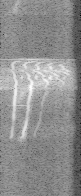

In [8]:
show_sample(24)

## Inspect (some) shapes

In [9]:
for idx in range(5):
    print(np.array(Image.open(paths_png[idx])).shape)

(140, 81)
(125, 81)
(150, 81)
(155, 81)
(161, 81)


## DataLoader

In [10]:
import fastbook
fastbook.setup_book()
from fastbook import *

In [11]:
# from torchvision import transforms
# transforms.Pad

This is what a loaded image looks like (when loaded as PILImageBW, we have no color channels)

In [12]:
np.array(PILImage.create(paths_png[0])).shape

(140, 81, 3)

In [13]:
np.array(PILImageBW.create(paths_png[0])).shape

(140, 81)

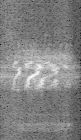

In [14]:
PILImageBW.create(paths_png[0])

Label for each sample can be extracted from its file name.
According to the authors:

Naming conventions follow the pattern C_NNNNN_BB_SS_OOOOO_RXX, which has to be exploded as follows:

- C = emission context (values: B = brushing; F = waiting for food; I: isolation in an unfamiliar environment);
- NNNNN = cat’s unique ID;
- BB = breed (values: MC = Maine Coon; EU: European Shorthair);
- SS = sex (values: FI = female, intact; FN: female, neutered; MI: male, intact; MN: male, neutered);
- OOOOO = cat owner’s unique ID;
- R = recording session (values: 1, 2 or 3)
- XX = vocalization counter (values: 01..99)




In [15]:

label_dict_situation = {
    'B': 'brushing',
    'F': 'hungry',
    'I': 'discomfort'
}
def label_func_situation(fname):
    # B = brushing; F = waiting for food; I: isolation in an unfamiliar environment
    return label_dict_situation[fname.name[0]]

def label_func_gender(fname):
    # returns M or F
    return fname.name[11].lower()

dict_breed = {'MC': "maine_coone", 'EU': 'european_shorthair'}
def label_func_breed(fname):
    return dict_breed[fname.name[8:10]]
    

def get_dataloaders(task, batch_size=128):
    label_func = {
        'situation': label_func_situation,
        'gender': label_func_gender,
        'breed': label_func_breed
    }[task]
    
#     tfms = [Rotate(), Zoom(), Warp(), Brightness(), Flip(), Contrast()]
# comp = setup_aug_tfms(tfms)
    data = DataBlock(
        blocks=(ImageBlock(cls=PILImage), CategoryBlock),
#         n_inp=1,  # how many blocks are input
        get_items=get_image_files,
        splitter=RandomSplitter(),  # TODO: clean split so that same cats doesn't appear in both sets
        item_tfms=[CropPad(81)],
        batch_tfms=setup_aug_tfms([Brightness(), Contrast()]),
        #         item_tfms=[Resize(81, method=ResizeMethod.Crop)],  # transforms.Pad(8), transforms.CenterCrop(81)
        get_y=label_func, 
    )
    
    return data, data.dataloaders(dataset_png, bs=batch_size)
datablock, dls = get_dataloaders('breed')

In [16]:
# datablock.summary(dataset_png)

**Looking at first batch:**

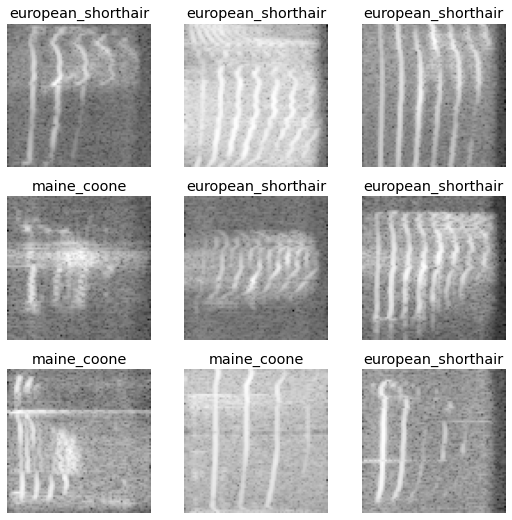

In [17]:
dls.show_batch()

fastai has also normalized the data to range 0..1 for us:

In [18]:
# one_sample.min().item(), one_sample.max().item()

In [19]:
# only works for single-channel
# plt.imshow(one_sample.squeeze(), cmap='gray', vmin=0, vmax=1)

In [20]:
# does this one look closer to what show_batch produces?
# plt.imshow((1./one_sample.squeeze()).log(), cmap='gray')

In [21]:
# how many classes?
dls.c

2

## ResNet: Determine cat's gender

In [22]:
def resnet(n_classes=3, pretrained=False):
    return create_cnn_model(models.resnet18, n_classes, pretrained)

In [23]:
def resnet_learner(callbacks=None, task='gender', pretrained=False):
    _, _dls = get_dataloaders(task)
    return Learner(
        _dls,
        resnet(n_classes=_dls.c, pretrained=pretrained),
        metrics=accuracy,
        cbs=callbacks
    )

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.0003311311302240938)

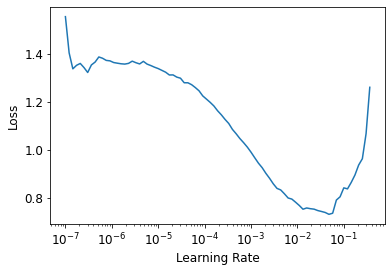

In [24]:
learn_resnet_lr = resnet_learner(pretrained=True)
learn_resnet_lr.lr_find()

In [25]:
learn_resnet = resnet_learner(ActivationStats(with_hist=True), pretrained=True)

In [26]:
learn_resnet.fit_one_cycle(10, 0.0001)

/home/flo/miniconda3/envs/practice-ml/lib/python3.7/site-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,1.511968,0.559949,0.795455,00:03
1,1.349098,0.550365,0.784091,00:02
2,1.243602,0.537186,0.761364,00:02
3,1.170228,0.586016,0.727273,00:02
4,1.080719,0.649083,0.670455,00:02
5,1.014789,0.710328,0.613636,00:02
6,0.961510,0.743616,0.579545,00:02
7,0.915886,0.745354,0.568182,00:02
8,0.891875,0.745326,0.579545,00:02
9,0.866361,0.758692,0.590909,00:02


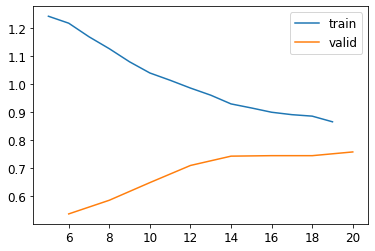

In [27]:
learn_resnet.recorder.plot_loss()

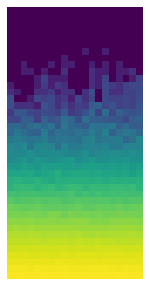

In [28]:
learn_resnet.activation_stats.color_dim(-2)

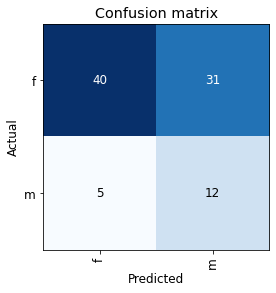

In [29]:
interpretation = ClassificationInterpretation.from_learner(learn_resnet)
interpretation.plot_confusion_matrix()

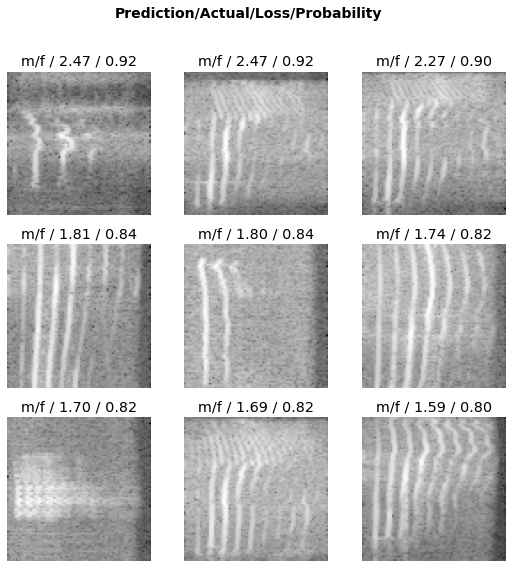

In [30]:
interpretation.plot_top_losses(9)

## ResNet: Which situation (or mood?) is the cat in (3 classes)

In [47]:
learn_situation = resnet_learner(task='situation', pretrained=True)

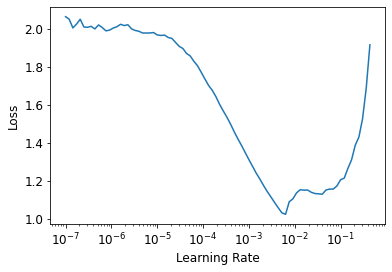

In [48]:
_, lr_steep = learn_situation.lr_find()

In [49]:
print(lr_steep)
learn_situation.fit_one_cycle(40, lr_steep)

0.00019054606673307717


epoch,train_loss,valid_loss,accuracy,time
0,2.154977,1.410183,0.420455,00:00
1,1.994852,1.221177,0.431818,00:00
2,1.897582,1.133563,0.431818,00:00
3,1.840854,1.073485,0.500000,00:00
4,1.734901,1.048327,0.500000,00:00
5,1.640046,1.029123,0.545455,00:00
6,1.522063,1.021484,0.545455,00:00
7,1.402691,1.014414,0.534091,00:00
8,1.314945,1.027637,0.534091,00:00
9,1.218985,1.049695,0.545455,00:00


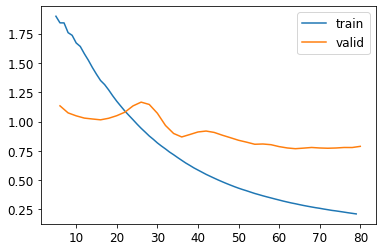

In [50]:
learn_situation.recorder.plot_loss()

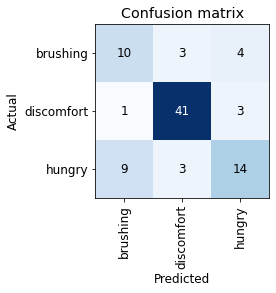

In [51]:
interpretation = ClassificationInterpretation.from_learner(learn_situation)
interpretation.plot_confusion_matrix()

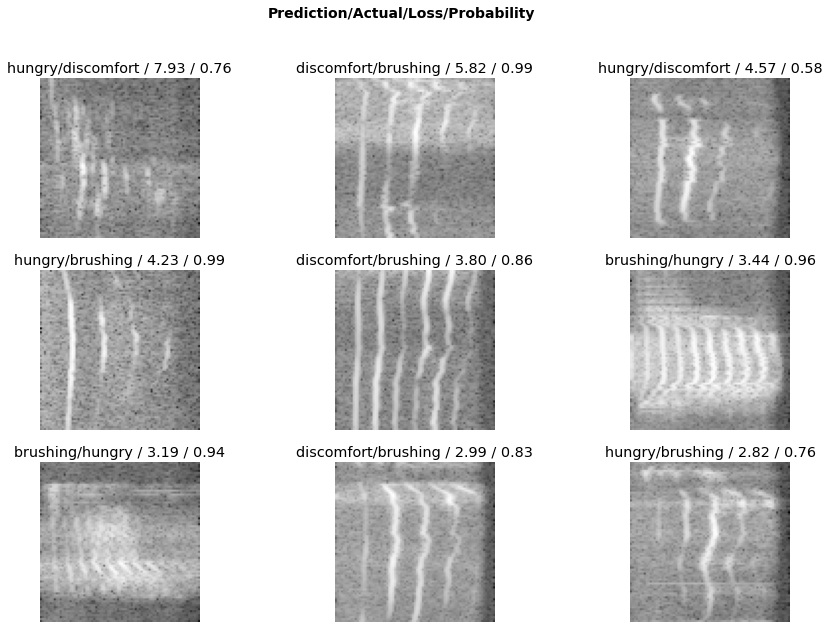

In [52]:
interpretation.plot_top_losses(9, figsize=(15, 10))

## ResNet: Can we tell the breed from the audio? (2 classes)

In [39]:
learn_breed = resnet_learner(task='breed', pretrained=True)

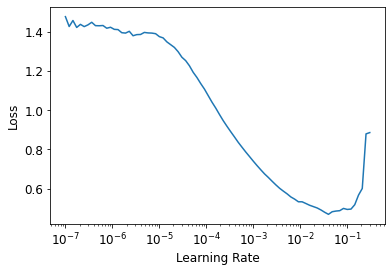

In [40]:
_, lr_steep = learn_breed.lr_find()

In [41]:
learn_breed.fit_one_cycle(30, lr_steep)

epoch,train_loss,valid_loss,accuracy,time
0,1.327547,1.279959,0.431818,00:00
1,1.335690,1.047682,0.409091,00:00
2,1.269954,0.947667,0.306818,00:00
3,1.255459,0.924526,0.340909,00:00
4,1.210071,0.950345,0.431818,00:00
5,1.158204,0.926948,0.454545,00:00
6,1.100999,0.891502,0.511364,00:00
7,1.036929,0.830738,0.534091,00:00
8,0.951864,0.741974,0.568182,00:00
9,0.876853,0.641769,0.681818,00:00


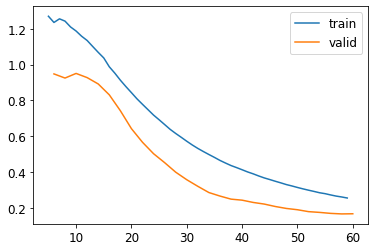

In [42]:
learn_breed.recorder.plot_loss()

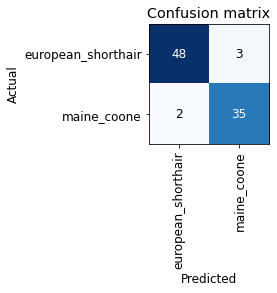

In [43]:
interpretation = ClassificationInterpretation.from_learner(learn_breed)
interpretation.plot_confusion_matrix()

## Ideas for improvement

Experiment with better data augmentation. Challenge: It can't just be any typical image augmentation, it should be sensible for the audio data. For example: Taking random crops along time axis makes sense. Taking crops from higher and lower in the spectrum: Maybe not too much, because then the absolute frequency information is lost.

## Custom ConvNet model

In [24]:
class cast_to_tensor(Module):
    "Workoaround: https://github.com/fastai/fastai/issues/2769#issuecomment-824186215"
    def forward(self, x):
        return cast(x, Tensor)

In [53]:
in_shape = (81, 81)  # time, frequencies, channels
n_classes = 3

# class Net(nn.Module):
#     def __init__(self, n_channels=3):
#         super().__init__()
#         self.conv1 = nn.Conv2d(n_channels, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         print(x.size())

#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         print(x.size())
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


def simple_net(n_channels=3):
    return nn.Sequential(
        nn.Conv2d(n_channels, 16, 5, stride=2),  # -> (8, ?, ?)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(),
        nn.Conv2d(16, 32, 3, stride=2),  # -> (16, ?, ?)
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout(),
        nn.Conv2d(32, 32, 3, stride=2), # -> (32, 9, 9)
        nn.BatchNorm2d(32),
        nn.Flatten(),
        nn.Linear(32*9*9, 256),
#       nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Linear(256, n_classes),
#       cast_to_tensor()
    )

net = simple_net()
print(net)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.5, inplace=False)
  (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=2592, out_features=256, bias=True)
  (12): ReLU()
  (13): Linear(in_features=256, out_features=3, bias=True)
)


In [54]:
sample = torch.randn(4, 3, 81, 81)
net(sample).shape

torch.Size([4, 3])

In [67]:
_, dls = get_dataloaders(task='situation')
learn_simplenet = Learner(
    dls,
    simple_net(),
#         loss_func=F.cross_entropy,  # <-- breaks confusion matrix for some reason
    metrics=accuracy,
    cbs=ActivationStats(with_hist=True)
)

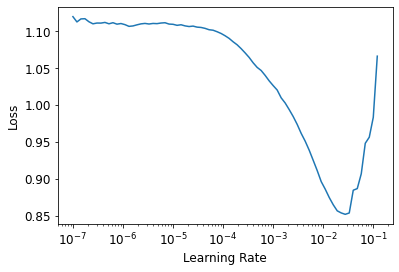

In [68]:
_, lr_steep = learn_simplenet.lr_find()

In [69]:
learn_simplenet.fit_one_cycle(20, lr_steep)

epoch,train_loss,valid_loss,accuracy,time
0,1.090240,1.093663,0.431818,00:01
1,1.013793,1.058404,0.477273,00:00
2,0.937546,1.030610,0.534091,00:00
3,0.865934,0.982662,0.568182,00:00
4,0.825630,1.063713,0.363636,00:00
5,0.783073,0.961260,0.556818,00:01
6,0.761220,0.950013,0.522727,00:00
7,0.736003,1.040801,0.511364,00:00
8,0.691269,0.910136,0.590909,00:00
9,0.660228,1.027834,0.500000,00:01


In [70]:
# def fit(epochs=20, lr=0.003):
#     learn = Learner(
#         dls,
#         simple_net(),
# #         loss_func=F.cross_entropy,
# #         loss_func=CrossEntropyLossFlat,
#         metrics=accuracy,
#         cbs=ActivationStats(with_hist=True)
#     )
#     learn.fit_one_cycle(epochs, lr)
#     return learn


# learn = fit(lr=lr_steep)

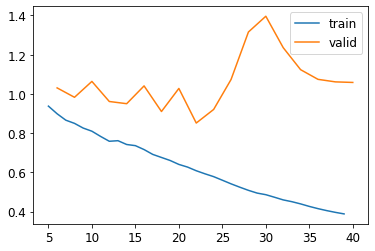

In [71]:
learn_simplenet.recorder.plot_loss()

In [64]:
learn.cbs

(#4) [TrainEvalCallback,Recorder,ProgressCallback,ActivationStats]

## Classification results

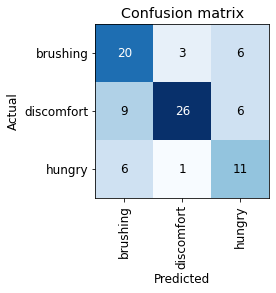

In [72]:
interpretation = ClassificationInterpretation.from_learner(learn_simplenet)
interpretation.plot_confusion_matrix()

### Activations on first layer

In [35]:
# learn.activation_stats.stats

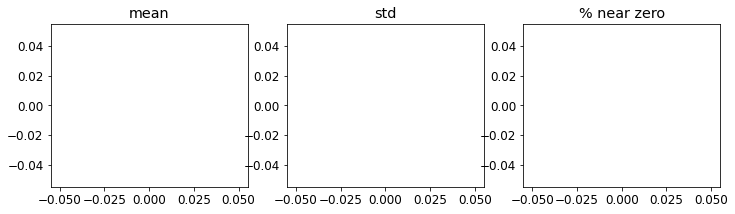

In [74]:
learn_simplenet.activation_stats.plot_layer_stats(0)

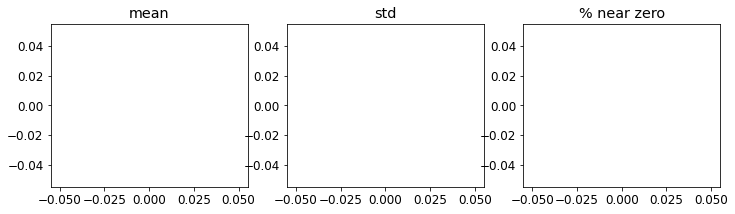

In [75]:
learn_simplenet.activation_stats.plot_layer_stats(-2)

In [76]:
learn_simplenet.activation_stats.color_dim(-2)

RuntimeError: stack expects a non-empty TensorList